# UW-Madison GI Tract Image Segmentation

## Data analysis & visualisation

## Load libaries 📚

In [1]:
#!/usr/bin/env python

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import re
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from glob import glob

import tensorflow as tf


In [2]:
%cd 'hpc_train_files'

/Users/viktor/Documents/BA/GIT/HealthyOrganTracker/hpc_train_files


In [3]:
from config import CFG
from dataloader import DataGenerator
from loss import dice_coef, iou_coef, dice_loss, bce_dice_loss
from datapreparation import extract_metadata, remove_faulties
from utility import rle_encode, rle_decode, build_masks, fix_empty_slices, is_isolated, fix_nc_slices

## Config ⚙️

In [4]:
BASE_PATH = 'input/uw-madison-gi-tract-image-segmentation/'
TRAIN_DIR =  BASE_PATH +'train'
TRAIN_CSV =  BASE_PATH +'train.csv'

"""
Backbones available: 
        'efficientnetb0'
        'efficientnetb1'
        'efficientnetb2'
        'efficientnetb3'
        'efficientnetb4'
        'efficientnetb5'
        'efficientnetb6'
        'efficientnetb7'
        'inceptionresnetv2'
        'inceptionv3'
        'resnet50'
        'resnext50'
        'resnext101'
        'seresnext50'
        'seresnext101'
        'densenet121'
        'densenet201'
        """

"\nBackbones available: \n        'efficientnetb0'\n        'efficientnetb1'\n        'efficientnetb2'\n        'efficientnetb3'\n        'efficientnetb4'\n        'efficientnetb5'\n        'efficientnetb6'\n        'efficientnetb7'\n        'inceptionresnetv2'\n        'inceptionv3'\n        'resnet50'\n        'resnext50'\n        'resnext101'\n        'seresnext50'\n        'seresnext101'\n        'densenet121'\n        'densenet201'\n        "

In [5]:
cfg = CFG(
    backbone            = 'efficientnetb0',
    img_dims            = (32,32,3),
    model               = 'UNet',
    batch_size          = 16, 
    epochs              = 1, 
    kaggle              = False, 
    use_fold_csv        = True,
    semi3d_data         = False,
    remove_faulty_cases = True,
    use_crop_data       = False)

In [6]:
df = pd.read_csv(cfg.train_csv)
#df = df.sample(n=90, random_state=1)

## Extract metadata

* Restructure frame
* Extract Case ID, Day and Slice
* Extract image path
* Extract image dimensions (width, height, pixelspacing)
* Extract amount of classes shown in slice

## 2.5D Data
* Adds depth to each slice
* Instead of a RGB channel we have: slice[0], slice[stride] amd slice[stride*2]

In [7]:
df_train = extract_metadata(df, TRAIN_DIR, channels=3, stride=2)
df_train.fillna('',inplace=True);

Frame merged. Shape: (38496, 22)
Remove faulty cases: True
Sucess. Shape: (38208, 22)


## Final table

In [8]:
df_train.sample(5)

,id,large_bowel,small_bowel,stomach,case,day,slice,case_day,path,width,...,pixel_y,count,path00,path01,path02,image_paths,rs,re,cs,ce
5845,case30_day1_slice_0086,18980 9 19243 14 19508 16 19773 18 19847 5 198...,25485 6 25750 9 26015 10 26280 12 26545 13 268...,18747 6 18755 3 19010 20 19274 24 19534 31 197...,30,1,86,case30_day1,input/uw-madison-gi-tract-image-segmentation/t...,266,...,1.50,3,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,50,10000,0,251
20675,case92_day0_slice_0020,,,,92,0,20,case92_day0,input/uw-madison-gi-tract-image-segmentation/t...,266,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,56,10000,0,266
25974,case121_day0_slice_0023,,,,121,0,23,case121_day0,input/uw-madison-gi-tract-image-segmentation/t...,266,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,44,10000,0,247
19508,case89_day0_slice_0085,31539 7 31897 11 32256 13 32616 16 32975 19 33...,42001 5 42360 9 42719 11 43066 5 43079 12 4342...,35082 11 35439 17 35797 22 36156 25 36515 28 3...,89,0,85,case89_day0,input/uw-madison-gi-tract-image-segmentation/t...,360,...,1.50,3,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,65,10000,0,360
2268,case11_day13_slice_0109,,,,11,13,109,case11_day13,input/uw-madison-gi-tract-image-segmentation/t...,360,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,65,10000,0,359


## Exploratory Data Analysis

* 57% of the slices have no segmentation at all
* Left bowel is most segmented, stomach least

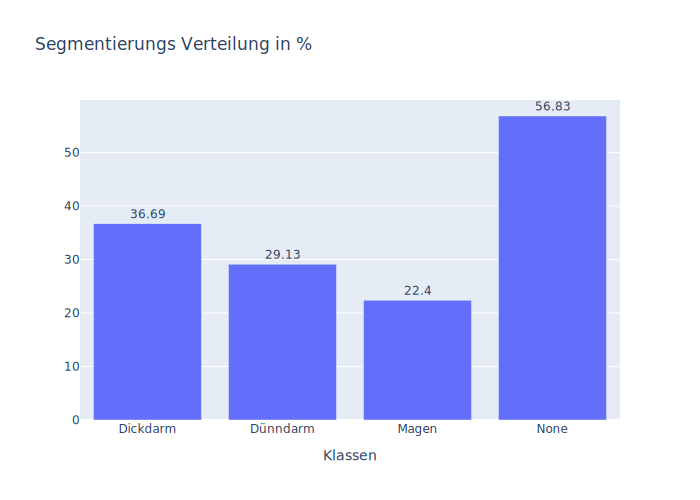

In [9]:
import plotly.graph_objects as go

if not os.path.exists("images"):
    os.mkdir("images")

dist = np.mean(df_train.iloc[:,1:4]!='',axis=0)
no_masks = np.sum(df_train['count'] == 0)/df_train.shape[0]
dist = np.round(np.append(dist.values, no_masks) * 100, 2)

fig = go.Figure([go.Bar(x=['Dickdarm', 'Dünndarm', 'Magen', 'None'], y=dist, text=dist, textposition='auto')])
fig.update_traces( textposition='outside')
fig.update_layout(title_text='Segmentierungs Verteilung in %', xaxis_title="Klassen")
fig.write_image("images/segmentation_distribution.png")
fig.show("svg")

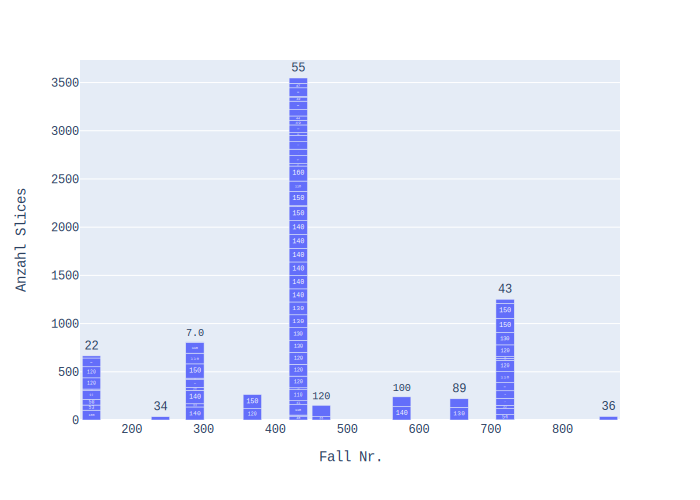

In [11]:
cases = df_train["case"].value_counts().reset_index()

fig = px.bar(cases, x='case', y='index', text_auto='.2s')
fig.update_layout(
    font_family="Courier New",
    xaxis_title="Fall Nr.",
    yaxis_title="Anzahl Slices",
)
fig.show("svg")

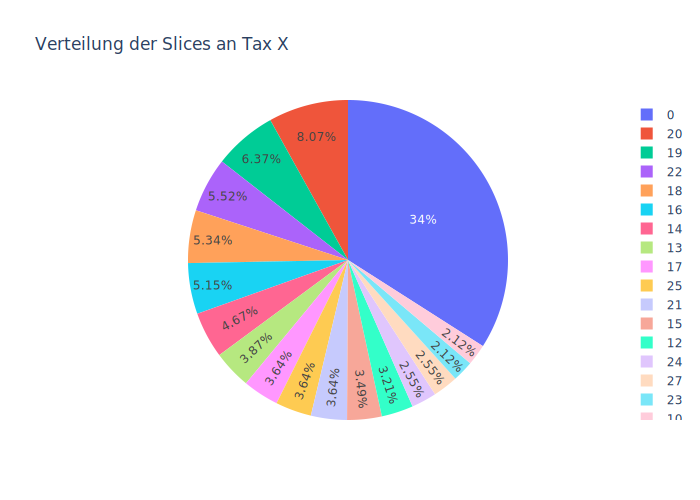

In [12]:
days = df_train["day"].value_counts().reset_index()
days = days.loc[days['day'] > 700]
fig = px.pie(days, values='day', names='index', title='Verteilung der Slices an Tax X')
fig.show('svg')

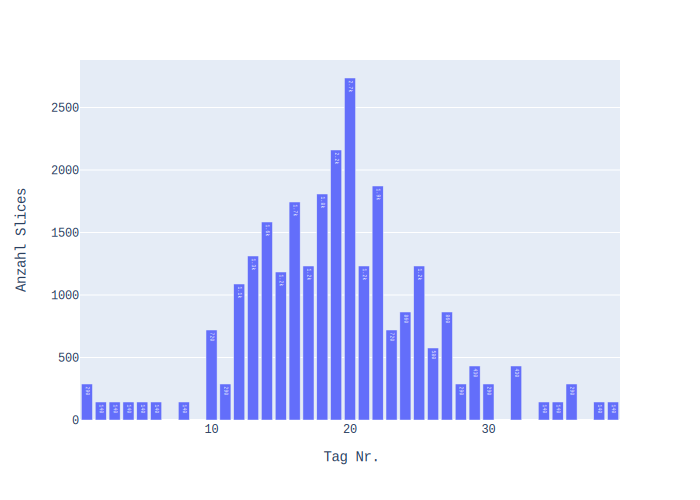

In [13]:
days_ = df_train["day"].value_counts().reset_index().iloc[1:,:]

fig = px.bar(days_, x='index', y='day', text_auto='.2s')
fig.update_layout(
    font_family="Courier New",
    xaxis_title="Tag Nr.",
    yaxis_title="Anzahl Slices",
)
fig.show('svg')

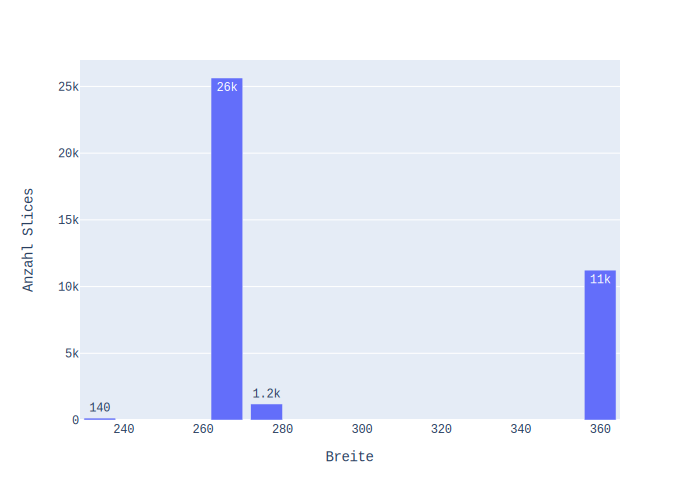

In [14]:
width = df_train["width"].value_counts().reset_index()

fig = px.bar(width, x='index', y='width', text_auto='.2s')
fig.update_layout(
    font_family="Courier New",
    xaxis_title="Breite",
    yaxis_title="Anzahl Slices",
)
fig.show('svg')

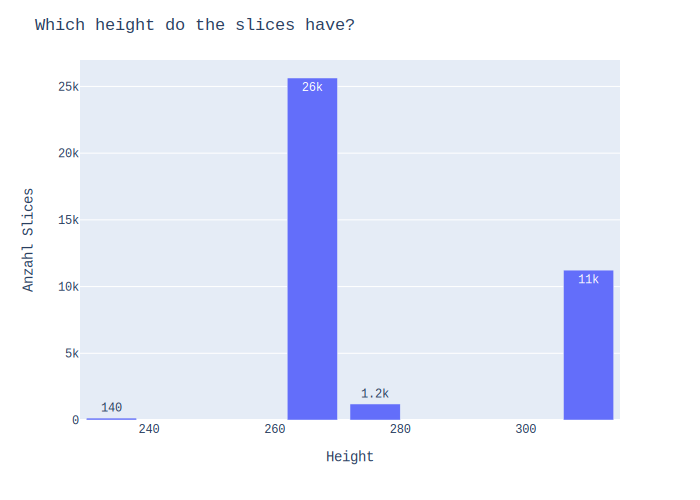

In [15]:
height = df_train["height"].value_counts().reset_index()

fig = px.bar(height, x='index', y='height', text_auto='.2s')
fig.update_layout(
    font_family="Courier New",
    title="Which height do the slices have?",
    xaxis_title="Height",
    yaxis_title="Anzahl Slices",
)
fig.show('svg')

In [16]:
df_train["pixel_x"].value_counts().reset_index()

,index,pixel_x
0,1.50,37008
1,1.63,1200


In [17]:
df_train["pixel_y"].value_counts().reset_index()

,index,pixel_y
0,1.50,37008
1,1.63,1200


In [18]:
def crop_image(x, img):
    rs = x['rs']
    re = x['re']
    cs = x['cs']
    ce = x['ce']
    return img[rs:re, cs:ce]

def ratio(df, class_name, crop=False):
    dff = pd.DataFrame()
    df['decoded'] = df.apply(lambda x: rle_decode(x[class_name], shape=(x['height'], x['width'])), axis = 1)
    dff['decoded'] = df['decoded'].copy()
    if crop:
        dff['decoded'] = df.apply(lambda x: crop_image(x, x['decoded']), axis=1)
        
    dff['foreground'] = dff['decoded'].apply(lambda x: np.count_nonzero(x))
    dff['background'] = dff.apply(lambda x: x.decoded.size - x.foreground, axis=1)
    
    ratio = dff['background'].sum() / dff['foreground'].sum()
    
    print("Ratio of background / foreground of class " + class_name + " is equal to " + str(ratio))
    
    return dff

In [19]:
sb = ratio(df_train, "small_bowel")

Ratio of background / foreground of class small_bowel is equal to 158.1246437868067


In [20]:
lb = ratio(df_train, "large_bowel")

Ratio of background / foreground of class large_bowel is equal to 144.0655948884801


In [21]:
stomach = ratio(df_train, "stomach")

Ratio of background / foreground of class stomach is equal to 285.1898484833969


In [22]:
background_average = (sb['background'].sum() + lb['background'].sum() + stomach['background'].sum() )/3

In [23]:
df['total'] = stomach['foreground'] + sb['foreground'] + lb['foreground']

total_ratio =  background_average / df['total'].sum()

In [24]:
total_ratio

59.64747632371314

In [25]:
sb_crop = ratio(df_train, "small_bowel", crop=True)

Ratio of background / foreground of class small_bowel is equal to 124.7782134467949


In [26]:
lb_crop = ratio(df_train, "large_bowel", crop=True)

Ratio of background / foreground of class large_bowel is equal to 113.6654026897017


In [27]:
stomach_crop = ratio(df_train, "stomach", crop=True)

Ratio of background / foreground of class stomach is equal to 225.21541825462432


In [28]:
background_average_crop = (sb_crop['background'].sum() + lb_crop['background'].sum() + stomach_crop['background'].sum() )/3

In [29]:
df['total'] = stomach_crop['foreground'] + sb_crop['foreground'] + lb_crop['foreground']

total_ratio_crop =  background_average_crop / df['total'].sum()

In [30]:
total_ratio_crop

47.077796082065724